---
# **Progetto B2**: Segmentation & Domain Shift Analysis
## **Corso**: Visione Computerizzata e Sistemi Cognitivi
**Obiettivo**: Costruire una U-Net per la segmentazione semantica e analizzare quanto il modello sia robusto quando i dati di test differiscono da quelli di training (Domain Shift).

Alessandro Scatto m: 0322500036
---

La base di partenza è una configurazione standard prendendo spunto dallo script nel GIT del corso lab05.ipynb (https://github.com/San-Raffaele-AI-Lab/VC_lab_05_aa25-26) che con Python & PyTorch addestra una rete convoluzionale di classificazione

Rispetto la laboratorio ho eseguito alcuni testdi valori della batch size per testare le performance del Runtime T4 GPU di Colab
Come learning rate parto dal default di Adam (la scelta di questo ottimizzatore sarà discussa nella relazione) farò dei successivi test empirici in fase di Model Selection
Parto  con un numero di epoche = 10 per poi verificare monitorando  le curve della Training Loss e della Validation Loss

Sto usando il device: cuda
Scaricamento dati in corso...
dati pronti caricati e normalizzati
3 immagini e maschere di esempio...


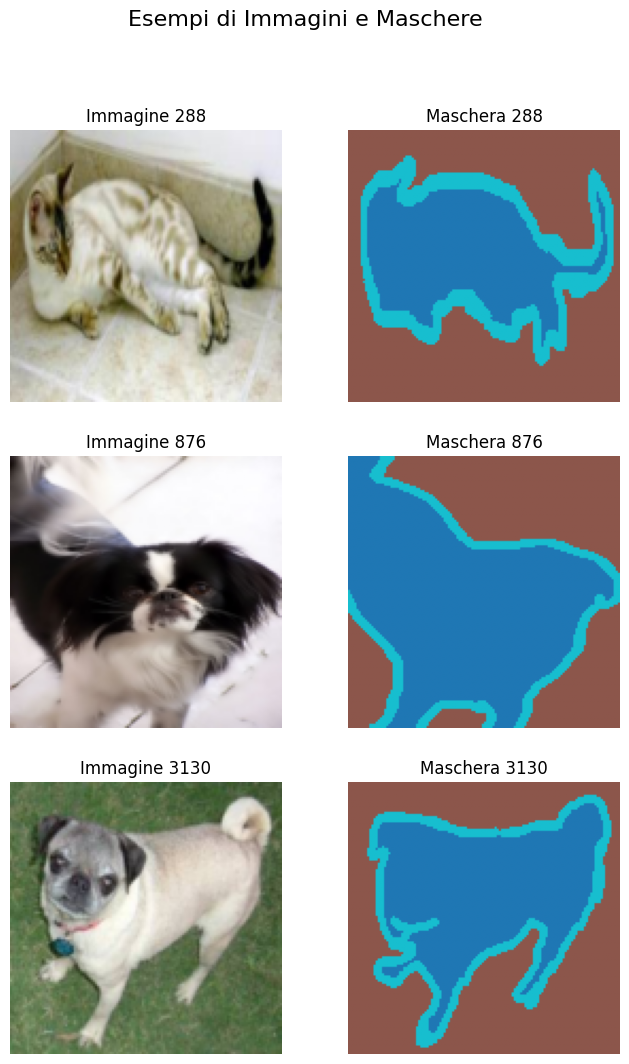

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
# from torchview import draw_graph
import random

# CONFIGURAZIONI
# Imposto la dimensione a 128x128  ed un batch_size adeguato per le performance disponibili utilizzando un Runtime T4 a GPU di COLAB
IMG_SIZE = 128
BATCH_SIZE = 128 # proviamo ad alzare se il runtime tiene
LEARNING_RATE = 0.001 # adam default poi si può provare a cambiare
EPOCHS = 20 # da tarare

# AGG. dopo varie prove ho visto che Colab ha tenuto fino ad un batch = 128
# AGG. ho aumentato a step il numero di EPOCHS fino a 20 verificando le curve della Training Loss e della Validation Loss

# Configurazione Device (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sto usando il device: {device}")

# ---------------------------------------------------------
# CARICAMENTO DEL DATASET Oxford-IIIT Pet
# ---------------------------------------------------------

# istanzio una pipeline per trasformare le immagini, faccio un resize alla dimensione predefinita e transformo in tensore PyTorch (normalizzando)
img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# in modo simile, ma lavorando su maschere di segmentazione, creo una pipeline per le maschere
# stavolta devo modificare l'interpolazione e non usare la normalizzazione
mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

# istanzio una classe che fa da adattatore, estendendo OxfordIIITPet
class OxfordPetDataset(datasets.OxfordIIITPet):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        # Le maschere originali hanno valori: 1 (animale), 2 (sfondo), 3 (bordo).
        # PyTorch prevede classi da 0, quindi sottraggo 1 agli elementi della maschera
        return img_transform(img), mask_transform(target) - 1

# utilizzando la nuova classe, scarico il dataset dividendo tra training e test
print("Scaricamento dati in corso...")
train_data = OxfordPetDataset(root='./data', split='trainval', target_types='segmentation', download=True)
test_data = OxfordPetDataset(root='./data', split='test', target_types='segmentation', download=True)

#train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
#test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
# provo ad aumentare la velocità

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("dati pronti caricati e normalizzati")

# Provo a visualizzare qualche immagine e maschera di esempio
print("3 immagini e maschere di esempio...")

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
fig.suptitle('Esempi di Immagini e Maschere', fontsize=16)

for i in range(3):
    #  prendo delle immagini casuali dal dataset di training
    idx = random.randint(0, len(train_data) - 1)
    img, mask = train_data[idx]

    # avendo caricato le immagini come tensori [C, H, W], le devo riordinare le dimensioni per matplotlib [H, W, C]
    img_display = img.permute(1, 2, 0).numpy()
    # anche le maschere sono tensori [C, H, W], per visualizzarle uso il metodo squeeze [H, W]
    mask_display = mask.squeeze().numpy()

    axes[i, 0].imshow(img_display)
    axes[i, 0].set_title(f'Immagine {idx}')
    axes[i, 0].axis('off')

    # Per visualizzare le classi (0, 1, 2) della maschera uso una colormap
    axes[i, 1].imshow(mask_display, cmap='tab10', vmin=0, vmax=2)
    axes[i, 1].set_title(f'Maschera {idx}')
    axes[i, 1].axis('off')

plt.show()

Per l'implementazione della U-Net da zero, ho studiato le best practices della community PyTorch e ho preso ispirazione dalle implementazioni open-source standard (rif: milesial/Pytorch-UNet)

Ho riadattato la loro implementazione alle specifiche esigenze del mio dataset (128x128 pixel, 3 classi). In particolare, ho mantenuto l'uso del modulo custom DoubleConv (con Batch Normalization) per mantenere il codice pulito e stabilizzare i gradienti, e ho integrato l'interpolazione dinamica (F.interpolate) prima delle Skip Connections.

In [6]:
# ---------------------------------------------------------
# COSTRUZIONE DI UNA ARCHITETTURA U-NET
# ---------------------------------------------------------


# incapsulo le operazioni convoluzionali nel modulo DoubleConv
# applico 2 convoluzioni spaziali con kernel 3x3 e padding 1
# all'interno inserisco il layer di Batch Normalization dopo ogni convoluzione
# questo stabilizzare il training prevenendo i vanishing gradient
# e la funzione di attivazione RELU per la non linearietà

class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# implementazione della U-NET che trasformi l'immagine in ingresso in una mappa di probabilità pixel x pixel
# come da letteratura è divisa in 3 fasi ENCODER (concentrazione) BOTTLENECK e DECODER (espansione)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # ENCODER (Discesa)
        # utilizzo la classe DoubleConv dopra definita e faccio seguire da 3 MaxPool
        # questa fase estrae il contesto semantico ("cosa" c'è nell'immagine), perdendo le informazioni spaziali di dettaglio
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))

        # BOTTLENECK (Il fondo della U)
        # informazioni altamente compresse ma semanticamente ricchissime
        self.bot = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # DECODER (Salita con Skip Connections)
        # utilizzo della Transposed Convolution per ricostruire i dettagli fini durante la fase di decoding e recuperare la risoluzione originale

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv_up1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv_up2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv_up3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv_up4 = DoubleConv(128, 64)

        # Layer finale: mappa i 64 canali risultanti nel numero di classi desiderate
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Discesa
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.bot(x4)

        # --- Fase di Salita & Skip Connections ---
        x = self.up1(x5)
        # Resize per gestire eventuali disallineamenti di pixel dovuti al padding
        # Concateniamo l'output dell'encoder con l'input del decoder

        if x.shape != x4.shape: x = F.interpolate(x, size=x4.shape[2:])
        # Skip Connection: Concateniamo lungo la dimensione dei canali (dim=1)
        x = torch.cat([x4, x], dim=1) # Skip Connection
        x = self.conv_up1(x)

        x = self.up2(x)
        if x.shape != x3.shape: x = F.interpolate(x, size=x3.shape[2:])
        x = torch.cat([x3, x], dim=1) # Skip Connection
        x = self.conv_up2(x)

        x = self.up3(x)
        if x.shape != x2.shape: x = F.interpolate(x, size=x2.shape[2:])
        x = torch.cat([x2, x], dim=1) # Skip Connection
        x = self.conv_up3(x)

        x = self.up4(x)
        if x.shape != x1.shape: x = F.interpolate(x, size=x1.shape[2:])
        x = torch.cat([x1, x], dim=1) # Skip Connection
        x = self.conv_up4(x)

        # Classificazione finale pixel-per-pixel
        logits = self.outc(x)
        return logits

Inizio Addestramento Modulare per Analisi Convergenza...
Epoch [1/20] | Train Loss: 0.7060 | Val Loss: 1.8572 | Val Acc: 0.6571
Epoch [2/20] | Train Loss: 0.5394 | Val Loss: 0.6915 | Val Acc: 0.7443
Epoch [3/20] | Train Loss: 0.4836 | Val Loss: 0.4864 | Val Acc: 0.8073
Epoch [4/20] | Train Loss: 0.4454 | Val Loss: 0.4809 | Val Acc: 0.8161
Epoch [5/20] | Train Loss: 0.4049 | Val Loss: 0.4119 | Val Acc: 0.8392
Epoch [6/20] | Train Loss: 0.3730 | Val Loss: 0.3927 | Val Acc: 0.8458
Epoch [7/20] | Train Loss: 0.3451 | Val Loss: 0.4575 | Val Acc: 0.8305
Epoch [8/20] | Train Loss: 0.3222 | Val Loss: 0.3353 | Val Acc: 0.8706
Epoch [9/20] | Train Loss: 0.3124 | Val Loss: 0.3675 | Val Acc: 0.8596
Epoch [10/20] | Train Loss: 0.2873 | Val Loss: 0.3264 | Val Acc: 0.8752
Epoch [11/20] | Train Loss: 0.2724 | Val Loss: 0.3127 | Val Acc: 0.8802
Epoch [12/20] | Train Loss: 0.2613 | Val Loss: 0.3325 | Val Acc: 0.8738
Epoch [13/20] | Train Loss: 0.2492 | Val Loss: 0.3388 | Val Acc: 0.8789
Epoch [14/20] | 

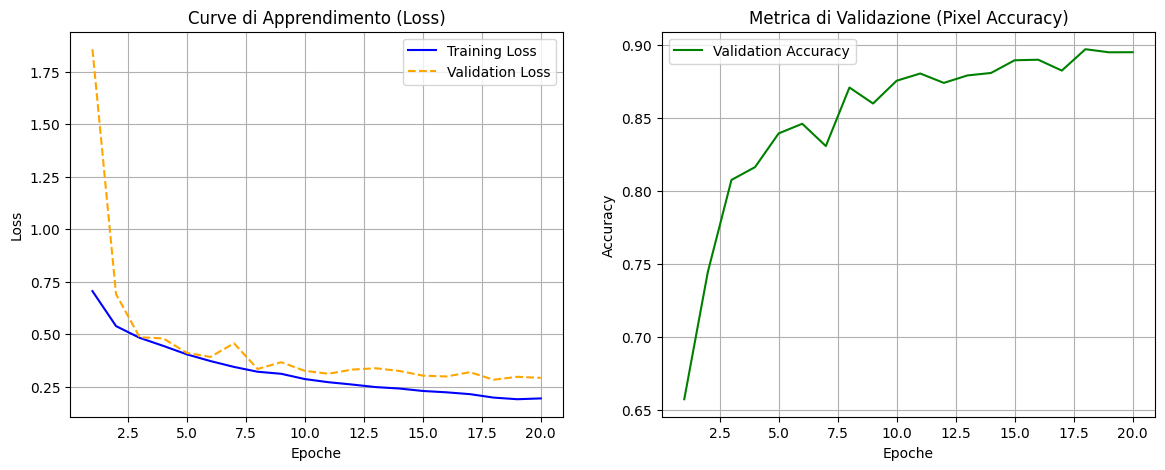

In [7]:
# ---------------------------------------------------------
# 3. TRAINING LOOP E VALIDAZIONE
# ---------------------------------------------------------

# Inizializziamo il modello e lo spostiamo sul device corretto (GPU/CPU)
model = UNet(n_channels=3, n_classes=3).to(device)

# Loss Function: CrossEntropy è lo standard per la classificazione multi-classe (pixel-wise)
criterion = nn.CrossEntropyLoss()
# Ottimizzatore: Adam garantisce una convergenza più veloce e stabile rispetto a SGD
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- FUNZIONE 1: Addestramento per singola epoca ---
def train_one_epoch(epoch_index, model, dataloader, criterion, optimizer, device):
    # model.train() è fondamentale: attiva il comportamento dinamico di layer come BatchNorm e Dropout
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        # Spostiamo i tensori sulla GPU per velocizzare il calcolo
        images = images.to(device)
        # La CrossEntropy richiede target di tipo 'long' (interi) e senza la dimensione del canale extra
        masks = masks.to(device).squeeze(1).long()

        optimizer.zero_grad()            # 1. Resettiamo i gradienti del batch precedente
        outputs = model(images)          # 2. Forward pass: la rete genera le predizioni
        loss = criterion(outputs, masks) # 3. Calcolo dell'errore rispetto alla Ground Truth
        loss.backward()                  # 4. Backward pass: calcolo dei gradienti
        optimizer.step()                 # 5. Ottimizzazione: aggiornamento dei pesi della rete

        running_loss += loss.item()

    # Calcoliamo la loss media per l'intera epoca
    avg_train_loss = running_loss / len(dataloader)
    return avg_train_loss

# --- FUNZIONE 2: Validazione ---
def validate(model, dataloader, criterion, device):
    # model.eval() "congela" BatchNorm e Dropout per garantire predizioni deterministiche
    model.eval()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    # torch.no_grad() disabilita il calcolo dei gradienti: fa risparmiare molta memoria VRAM e velocizza l'inferenza
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).squeeze(1).long()

            # Forward pass e calcolo loss
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            # --- Calcolo della Pixel Accuracy ---
            # outputs ha forma [Batch, Classi, H, W]. argmax(dim=1) seleziona la classe più probabile per ogni pixel
            preds = torch.argmax(outputs, dim=1)
            # torch.eq confronta predizioni e target pixel per pixel. .sum() conta i pixel corretti
            correct_pixels += torch.eq(preds, masks).sum().item()
            total_pixels += torch.numel(preds) # Numero totale di pixel nel batch

    # Medie finali per l'epoca
    avg_val_loss = running_loss / len(dataloader)
    avg_val_acc = correct_pixels / total_pixels
    return avg_val_loss, avg_val_acc

# ---------------------------------------------------------
# 4 CICLO PRINCIPALE E TRACCIAMENTO METRICHE
# ---------------------------------------------------------
print("Inizio Addestramento Modulare per Analisi Convergenza...")

# Dizionario per storicizzare l'andamento delle metriche epoca per epoca.
# Fondamentale per generare i grafici di diagnostica finali.
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # Esecuzione sequenziale: prima impara (train), poi viene interrogato (validate)
    train_loss = train_one_epoch(epoch, model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)

    # Salvataggio dei risultati nel dizionario
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Feedback in console per monitorare l'avanzamento in tempo reale
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# ---------------------------------------------------------
# STAMPA DEI GRAFICI FINALI (Diagnostica del Modello)
# ---------------------------------------------------------
print("Training completato. Generazione grafici di convergenza...")

# Creiamo l'asse X (il numero delle epoche da 1 a N)
epochs_range = range(1, EPOCHS + 1)

# Impostiamo la dimensione della "tela" (14 pollici di larghezza, 5 di altezza)
plt.figure(figsize=(14, 5))

# --- Grafico 1: Curve di Loss ---
# plt.subplot(1, 2, 1) significa: 1 riga, 2 colonne, posizionati nel 1° riquadro (sinistra)
plt.subplot(1, 2, 1)
# Tracciamo la loss di training (blu continua) e validazione (arancione tratteggiata)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='blue')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Curve di Apprendimento (Loss)')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) # Aggiunge la griglia per facilitare la lettura dei valori

# --- Grafico 2: Curva di Accuracy ---
# plt.subplot(1, 2, 2) significa: 1 riga, 2 colonne, posizionati nel 2° riquadro (destra)
plt.subplot(1, 2, 2)
# Tracciamo l'accuratezza di validazione sui pixel (verde)
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy', color='green')
plt.title('Metrica di Validazione (Pixel Accuracy)')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Mostriamo a schermo la figura completa
plt.show()

Generazione delle previsioni su immagini casuali del Test Set...


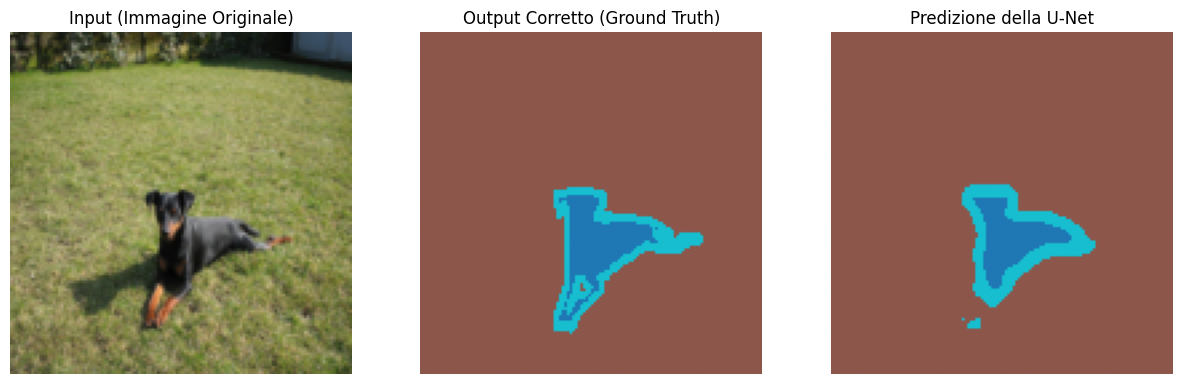

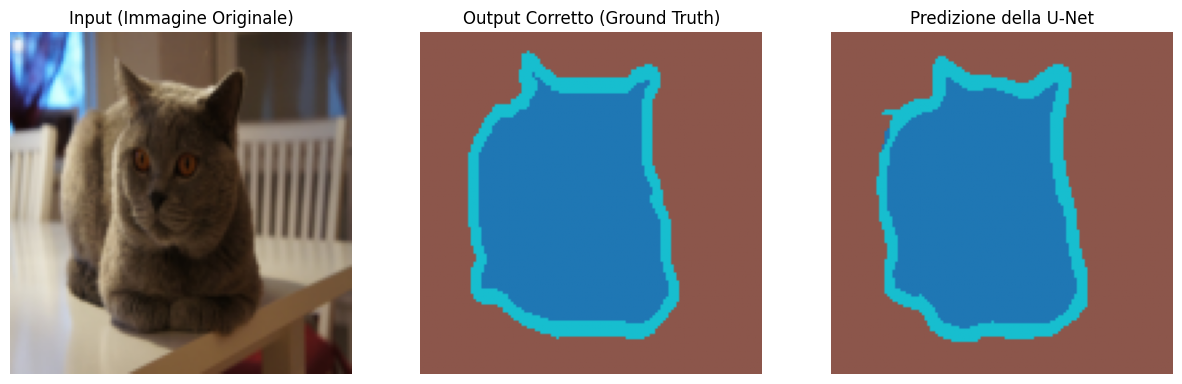

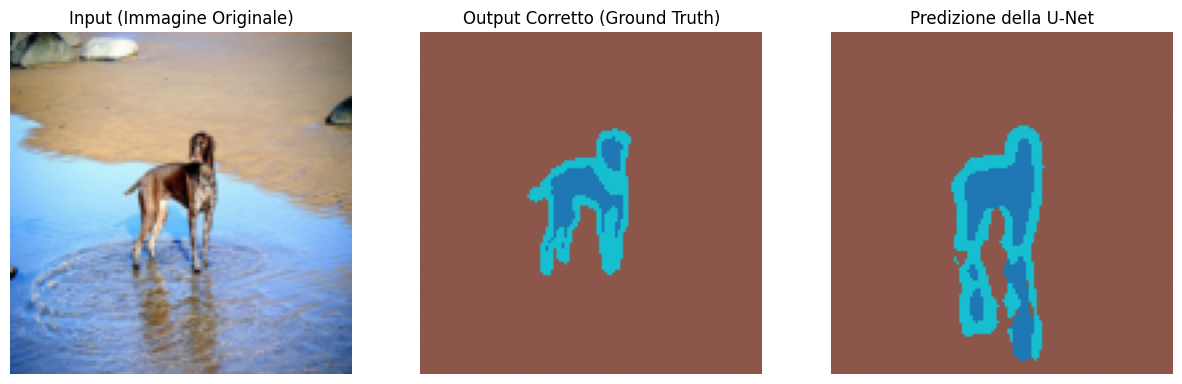

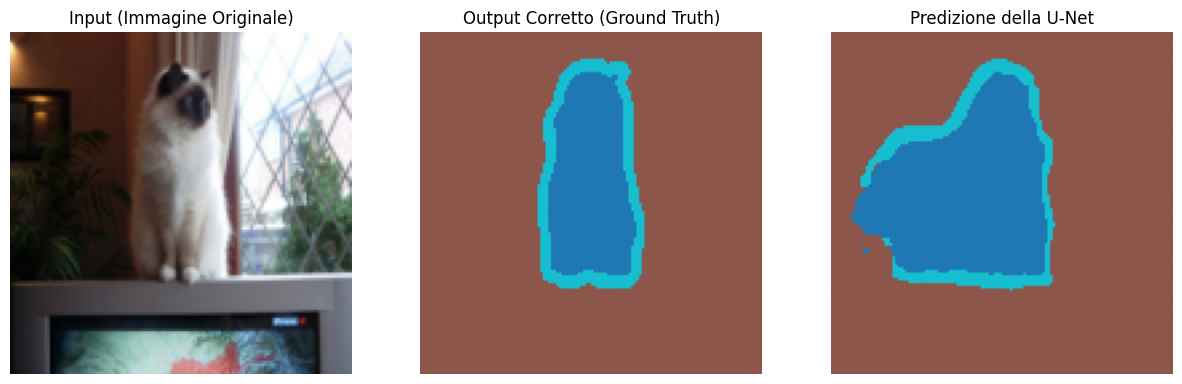

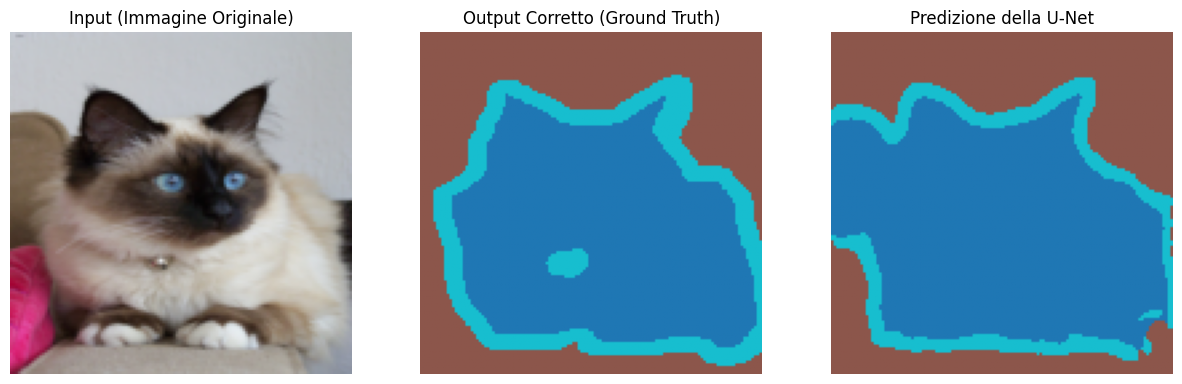

In [9]:
# ---------------------------------------------------------
# 5 INFERENZA E VISUALIZZAZIONE RISULTATI
# ---------------------------------------------------------

def show_results(model, dataset, num_samples=5, device='cpu'):
    # 1. Congeliamo i pesi e disattiviamo il calcolo dei gradienti
    model.eval()

    # 2. Selezioniamo indici casuali per testare la rete su animali sempre diversi
    indici = random.sample(range(len(dataset)), num_samples)

    for idx in indici:
        image, mask = dataset[idx]

        # 3. Preparazione dell'input per PyTorch
        # L'immagine singola ha shape [C, H, W].
        # unsqueeze(0) aggiunge la dimensione del batch fittizia -> [1, C, H, W]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad(): # Risparmiamo VRAM disabilitando il backprop
            output = model(input_tensor)

            # 4. Estrazione della mappa delle classi (argmax)
            # output ha shape [1, 3, H, W]. argmax collassa la dimensione delle classi.
            # squeeze(0) rimuove il batch fittizio per tornare a [H, W]
            prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # 5. Prepariamo le immagini originali per Matplotlib
        # Da [C, H, W] di PyTorch a [H, W, C] per le immagini RGB
        img_display = image.permute(1, 2, 0).numpy()
        mask_display = mask.squeeze(0).numpy() # Rimuove la dim canale dalla maschera

        # 6. Plotting
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(img_display)
        ax[0].set_title("Input (Immagine Originale)")
        ax[0].axis('off')

        # Usiamo vmin=0 e vmax=2 per garantire che i 3 colori (0, 1, 2) siano mappati correttamente
        ax[1].imshow(mask_display, cmap='tab10', vmin=0, vmax=2)
        ax[1].set_title("Output Corretto (Ground Truth)")
        ax[1].axis('off')

        ax[2].imshow(prediction, cmap='tab10', vmin=0, vmax=2)
        ax[2].set_title("Predizione della U-Net")
        ax[2].axis('off')

        plt.show()

# Lancia la visualizzazione passando il test_data e il tuo device
print("Generazione delle previsioni su immagini casuali del Test Set...")
show_results(model, test_data, num_samples=5, device=device)